# Ejercicio 3 — Naive Bayes Multinomial para Clasificación de Texto (Spam)

**Objetivo**: Investigar y explicar cómo modificar el modelo Naive Bayes para variables categóricas usando **Multinomial Naive Bayes** y aplicarlo en clasificación de spam.

## ¿Qué es Naive Bayes Multinomial?

**Multinomial Naive Bayes** es una variante del clasificador Naive Bayes diseñada para datos de **conteo discreto** (frecuencias), como la cantidad de veces que una palabra aparece en un documento.

### Diferencias entre variantes de Naive Bayes:

| Variante | Tipo de datos | Uso típico |
|----------|---------------|----------------|
| **GaussianNB** | Características continuas (distribución normal) | Datos numéricos (ej: altura, peso, sensores) |
| **MultinomialNB** | Conteos discretos (frecuencias) | Clasificación de texto, análisis de documentos |
| **BernoulliNB** | Variables binarias (0/1, presencia/ausencia) | Clasificación de texto con vectores binarios |

### ¿Por qué Multinomial para texto?

En clasificación de texto:
- Cada documento se representa como un **vector de frecuencias de palabras** (bag-of-words).
- Ejemplo: "comprar viagra ahora" → `{comprar: 1, viagra: 1, ahora: 1}`.
- MultinomialNB modela la probabilidad de que una palabra aparezca N veces en un documento de clase C.

**Fórmula**:

$$P(C|D) \propto P(C) \prod_{i=1}^{n} P(w_i|C)^{count(w_i)}$$

Donde:
- $C$ = clase (spam o ham)
- $D$ = documento (mensaje)
- $w_i$ = palabra i
- $count(w_i)$ = frecuencia de la palabra i en el documento

## Implementación práctica: Clasificación de Spam

Usaremos el dataset **SMS Spam Collection** que contiene mensajes de texto etiquetados como spam o ham (no spam).

In [1]:
# Imports necesarios
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay)
sns.set(style='whitegrid')

# Para este ejemplo, crearemos un dataset sintético de spam
# En un caso real, descargarías el SMS Spam Collection de UCI ML Repository
print('Librerías importadas correctamente')

Librerías importadas correctamente


In [2]:
# Crear un dataset sintético de mensajes spam/ham para demostración
# En producción, usarías un dataset real como SMS Spam Collection

spam_messages = [
    'Felicidades! Ganaste un premio de $1000. Haz clic aquí ahora',
    'URGENTE: Tu cuenta será cerrada. Verifica tus datos YA',
    'Compra viagra barato, envío gratis, haz clic ahora',
    'Gana dinero fácil desde casa, llama al 900-xxx-xxx',
    'Oferta especial solo hoy! 90% descuento en medicamentos',
    'Únete a nuestro casino online, bono de bienvenida $500',
    'Has ganado un iPhone gratis! Reclama tu premio ahora',
    'Préstamos rápidos sin aval, aprobación inmediata',
    'Aumenta tus ingresos trabajando desde casa, info aquí',
    'Oferta limitada: relojes de lujo a precios increíbles',
    'Consigue crédito instantáneo, sin papeleos, haz clic',
    'Descuento masivo en productos farmacéuticos online',
    'Gana dinero respondiendo encuestas, regístrate ya',
    'Alerta: problema con tu tarjeta, actualiza datos urgente',
    'Felicidades ganador! Cobra tu premio llamando ahora',
]

ham_messages = [
    'Hola, ¿cómo estás? ¿Nos vemos mañana para café?',
    'Recordatorio: reunión de equipo a las 3pm en sala B',
    'Gracias por tu correo, revisaremos la propuesta',
    '¿Puedes enviarme el informe que discutimos ayer?',
    'Confirmé tu cita para el lunes a las 10am',
    'El paquete llegó, muchas gracias por el envío',
    '¿Qué tal estuvo tu fin de semana? Espero que bien',
    'Te llamo en 10 minutos para discutir el proyecto',
    'Adjunto el documento que me solicitaste',
    'Feliz cumpleaños! Que tengas un día excelente',
    'La presentación está lista, la revisaré contigo',
    'Gracias por tu ayuda con el problema técnico',
    '¿A qué hora terminas hoy? Podemos coordinarnos',
    'Recibido, procedo con los cambios solicitados',
    'La fecha de entrega está confirmada para el viernes',
]

# Crear DataFrame
data = {
    'message': spam_messages + ham_messages,
    'label': ['spam']*len(spam_messages) + ['ham']*len(ham_messages)
}

df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Mezclar

print(f'Total de mensajes: {len(df)}')
print(f'\nDistribución:')
print(df['label'].value_counts())
print('\nPrimeros mensajes:')
df.head(10)

Total de mensajes: 30

Distribución:
label
ham     15
spam    15
Name: count, dtype: int64

Primeros mensajes:


,message,label
0,¿A qué hora terminas hoy? Podemos coordinarnos,ham
1,"Hola, ¿cómo estás? ¿Nos vemos mañana para café?",ham
2,Adjunto el documento que me solicitaste,ham
3,"Gracias por tu correo, revisaremos la propuesta",ham
4,"Aumenta tus ingresos trabajando desde casa, in...",spam
5,Oferta limitada: relojes de lujo a precios inc...,spam
6,"Recibido, procedo con los cambios solicitados",ham
7,Feliz cumpleaños! Que tengas un día excelente,ham
8,"Gana dinero respondiendo encuestas, regístrate ya",spam
9,Felicidades! Ganaste un premio de $1000. Haz c...,spam


## Vectorización de texto

Para que Naive Bayes pueda procesar texto, necesitamos convertir los mensajes en **vectores numéricos**. Hay dos enfoques principales:

### 1. **CountVectorizer** (Bag of Words)
- Cuenta cuántas veces aparece cada palabra en el documento.
- Ejemplo: "comprar viagra" → `{comprar: 1, viagra: 1}`

### 2. **TfidfVectorizer** (Term Frequency - Inverse Document Frequency)
- Pondera las palabras según su importancia.
- Palabras comunes ("el", "la") tienen menor peso.
- Palabras raras pero informativas tienen mayor peso.

Usaremos **CountVectorizer** para Multinomial NB (funciona mejor con conteos puros).

In [3]:
# Dividir en train/test
X = df['message']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f'Conjunto de entrenamiento: {len(X_train)} mensajes')
print(f'Conjunto de prueba: {len(X_test)} mensajes')

Conjunto de entrenamiento: 22 mensajes
Conjunto de prueba: 8 mensajes


In [4]:
# Vectorizar el texto con CountVectorizer
vectorizer = CountVectorizer(
    lowercase=True,          # Convertir a minúsculas
    stop_words=None,         # No eliminar stopwords para este ejemplo simple
    max_features=100,        # Limitar a las 100 palabras más frecuentes
    ngram_range=(1, 2)       # Usar unigramas y bigramas
)

# Transformar train y test
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(f'Dimensión del vocabulario: {len(vectorizer.vocabulary_)} palabras')
print(f'Forma de X_train vectorizado: {X_train_vec.shape}')
print(f'Forma de X_test vectorizado: {X_test_vec.shape}')

# Mostrar algunas palabras del vocabulario
print(f'\nAlgunas palabras del vocabulario:')
print(list(vectorizer.vocabulary_.keys())[:20])

Dimensión del vocabulario: 100 palabras
Forma de X_train vectorizado: (22, 100)
Forma de X_test vectorizado: (8, 100)

Algunas palabras del vocabulario:
['felicidades', 'un', 'premio', 'de', '1000', 'haz', 'clic', 'aquí', 'ahora', 'un premio', 'de 1000', '1000 haz', 'haz clic', 'clic aquí', 'enviarme', 'el', 'que', 'discutimos', 'discutimos ayer', 'la']


## Entrenamiento del modelo MultinomialNB

Ahora entrenaremos el clasificador **Multinomial Naive Bayes** con los vectores de conteo.

In [5]:
# Crear y entrenar MultinomialNB
mnb = MultinomialNB(alpha=1.0)  # alpha es el parámetro de suavizado de Laplace
mnb.fit(X_train_vec, y_train)

# Predicciones
y_pred_train = mnb.predict(X_train_vec)
y_pred_test = mnb.predict(X_test_vec)

print('Modelo MultinomialNB entrenado correctamente!')

Modelo MultinomialNB entrenado correctamente!


## Evaluación del modelo

In [6]:
# Métricas en conjunto de prueba
acc = accuracy_score(y_test, y_pred_test)
prec = precision_score(y_test, y_pred_test, pos_label='spam')
rec = recall_score(y_test, y_pred_test, pos_label='spam')
f1 = f1_score(y_test, y_pred_test, pos_label='spam')

print('=== MÉTRICAS EN CONJUNTO DE PRUEBA ===')
print(f'Accuracy:  {acc:.4f}')
print(f'Precision (spam): {prec:.4f}')
print(f'Recall (spam):    {rec:.4f}')
print(f'F1-Score (spam):  {f1:.4f}')

print('\n=== CLASSIFICATION REPORT ===')
print(classification_report(y_test, y_pred_test, target_names=['ham', 'spam']))

=== MÉTRICAS EN CONJUNTO DE PRUEBA ===
Accuracy:  1.0000
Precision (spam): 1.0000
Recall (spam):    1.0000
F1-Score (spam):  1.0000

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         ham       1.00      1.00      1.00         4
        spam       1.00      1.00      1.00         4

    accuracy                           1.00         8
   macro avg       1.00      1.00      1.00         8
weighted avg       1.00      1.00      1.00         8



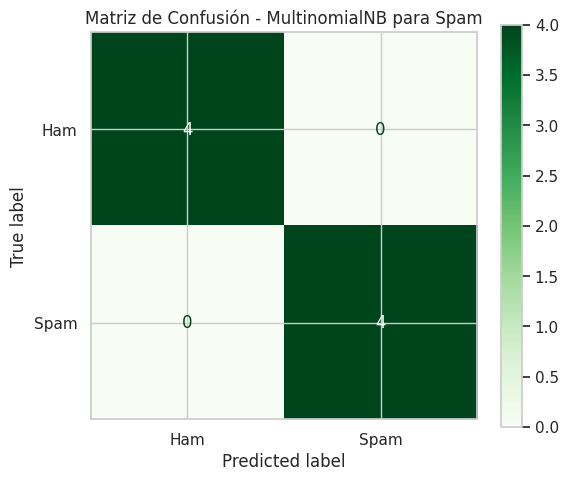

In [7]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_test, labels=['ham', 'spam'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Ham', 'Spam'])

fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, cmap='Greens', values_format='d')
plt.title('Matriz de Confusión - MultinomialNB para Spam')
plt.tight_layout()
plt.show()

## Probando el modelo con nuevos mensajes

In [9]:
# Nuevos mensajes para clasificar
nuevos_mensajes = [
    'Hola, ¿podemos reunirnos mañana a las 10?',
    'FELICIDADES ganaste un premio de 5000 euros, haz clic YA',
    'El proyecto está listo para revisión',
    'Oferta especial viagra barato urgente haz clic ahora',
]

# Vectorizar los nuevos mensajes
nuevos_vec = vectorizer.transform(nuevos_mensajes)

# Predecir
predicciones = mnb.predict(nuevos_vec)
probabilidades = mnb.predict_proba(nuevos_vec)

# Mostrar resultados
print('=== PREDICCIONES EN NUEVOS MENSAJES ===\n')
for i, msg in enumerate(nuevos_mensajes):
    pred = predicciones[i]
    prob_ham = probabilidades[i][0]
    prob_spam = probabilidades[i][1]
    print(f'Mensaje: "{msg}"')
    print(f'Predicción: {pred.upper()}')
    print(f'Probabilidades: Ham={prob_ham:.3f}, Spam={prob_spam:.3f}')
    print('-' * 80)

=== PREDICCIONES EN NUEVOS MENSAJES ===

Mensaje: "Hola, ¿podemos reunirnos mañana a las 10?"
Predicción: HAM
Probabilidades: Ham=0.500, Spam=0.500
--------------------------------------------------------------------------------
Mensaje: "FELICIDADES ganaste un premio de 5000 euros, haz clic YA"
Predicción: SPAM
Probabilidades: Ham=0.004, Spam=0.996
--------------------------------------------------------------------------------
Mensaje: "El proyecto está listo para revisión"
Predicción: HAM
Probabilidades: Ham=0.991, Spam=0.009
--------------------------------------------------------------------------------
Mensaje: "Oferta especial viagra barato urgente haz clic ahora"
Predicción: SPAM
Probabilidades: Ham=0.000, Spam=1.000
--------------------------------------------------------------------------------


## Comparación: MultinomialNB vs GaussianNB en texto

Veamos qué pasa si intentamos usar **GaussianNB** (diseñado para variables continuas) en datos de texto.

In [10]:
# Entrenar GaussianNB (requiere matriz densa)
gnb = GaussianNB()
gnb.fit(X_train_vec.toarray(), y_train)  # Convertir matriz sparse a densa

# Predicciones con GaussianNB
y_pred_gnb = gnb.predict(X_test_vec.toarray())

# Métricas
acc_gnb = accuracy_score(y_test, y_pred_gnb)
acc_mnb = accuracy_score(y_test, y_pred_test)

print('=== COMPARACIÓN DE MODELOS ===')
print(f'MultinomialNB Accuracy: {acc_mnb:.4f}')
print(f'GaussianNB Accuracy:    {acc_gnb:.4f}')
print(f'\nDiferencia: {acc_mnb - acc_gnb:.4f}')

if acc_mnb > acc_gnb:
    print('\n✓ MultinomialNB es MEJOR para clasificación de texto')
else:
    print('\n✓ GaussianNB tiene mejor desempeño')

=== COMPARACIÓN DE MODELOS ===
MultinomialNB Accuracy: 1.0000
GaussianNB Accuracy:    0.8750

Diferencia: 0.1250

✓ MultinomialNB es MEJOR para clasificación de texto


## Conclusiones y mejores prácticas

### ¿Cuándo usar MultinomialNB?

1. **Clasificación de texto**: Spam, sentimientos, categorización de documentos
2. **Datos de conteo**: Frecuencias de palabras, n-gramas, histogramas discretos
3. **Datasets grandes**: Es muy rápido de entrenar y predecir
4. **Baseline rápido**: Excelente punto de partida antes de modelos complejos

### Ventajas de MultinomialNB:

- ✅ **Rápido**: Entrenamiento e inferencia muy eficientes
- ✅ **Pocos datos**: Funciona bien incluso con datasets pequeños
- ✅ **Interpretable**: Fácil entender qué palabras indican spam/ham
- ✅ **Robusto**: Maneja bien features irrelevantes

### Limitaciones:

- ❌ **Supuesto de independencia**: Ignora el orden y contexto de las palabras
- ❌ **Vocabulario limitado**: No maneja bien palabras nuevas (out-of-vocabulary)
- ❌ **Sin semántica**: No entiende sinónimos ni significados

